In [1]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, device):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1
        self.batch_size = batch_size
        self.device = device
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=False)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(self.device)
        output, (h, c) = self.lstm(input_seq, (h_0, c_0))

        # 只返回隐状态和单元状态
        return h, c

In [2]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq, h, c):
        # input_seq(batch_size, input_size)
        batch_size = input_seq.shape[0]
        input_seq = input_seq.view(batch_size, 1, self.input_size)
        output, (h, c) = self.lstm(input_seq, (h, c))
        # output(batch_size, seq_len, num * hidden_size)
        pred = self.linear(output)  # pred(batch_size, 1, output_size)
        pred = pred[:, -1, :]

        return pred, h, c

In [3]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, device):
        super().__init__()
        self.output_size = output_size
        self.device = device
        self.Encoder = Encoder(input_size, hidden_size, num_layers, batch_size, device)
        self.Decoder = Decoder(input_size, hidden_size, num_layers, output_size, batch_size)

    def forward(self, input_seq):
        batch_size, seq_len, _ = input_seq.shape[0], input_seq.shape[1], input_seq.shape[2]
        h, c = self.Encoder(input_seq)
        outputs = torch.zeros(batch_size, seq_len, self.output_size).to(self.device)
        for t in range(seq_len):
            _input = input_seq[:, t, :]
            output, h, c = self.Decoder(_input, h, c)
            outputs[:, t, :] = output

        return outputs[:, -1, :]


In [69]:
import pandas as pd
import sys

sys.path.append("./practice/covid19")

df = pd.read_csv("./practice/covid19/dataset/Delaware.csv")
# df = df[df.REGION == "New York"]

df_use = df[["REGION", "YEAR", "WEEK", "ili_ratio"]]
df_use = df_use[50:]
df_use.index = range(len(df_use))

df_use = (df_use.loc[:, ["ili_ratio"]])  # 只用ili_ratio
df_use

,ili_ratio
0,0.000000
1,0.000000
2,0.001608
3,0.001131
4,0.000638
...,...
574,0.011423
575,0.009824
576,0.009270
577,0.012565


In [70]:
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import numpy as np
import torch

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def nn_seq_us(batch_size):
    print('data processing...')
    dataset = df_use
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])

    def process(data, batch_size, shuffle):
        load = data[data.columns[0]]
        load = load.tolist()
        data = data.values.tolist()
        load = (load - n) / (m - n)
        seq = []
        for i in range(len(data) - 24):
            train_seq = []
            train_label = []
            for j in range(i, i + 24):
                x = [load[j]]
                train_seq.append(x)
            # for c in range(2, 8):
            #     train_seq.append(data[i + 24][c])
            train_label.append(load[i + 24])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        # print(seq[-1])
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    data_train = process(train, batch_size, True)
    data_validate = process(val, batch_size, True)
    data_test = process(test, batch_size, False)

    return data_train, data_validate, data_test, m, n

In [71]:
from torch.optim.lr_scheduler import StepLR as StepLR
from tqdm import tqdm
from copy import deepcopy

def get_val_loss(model, Val, loss_function, device):
    model.eval()
    val_loss = []
    for (seq, label) in Val:
        seq = seq.to(device)
        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        val_loss.append(loss.item())

    return sum(val_loss)/len(val_loss)# MSE


def lstm_train(data_train, Val, path, input_size=1, hidden_size=10, num_layers=2, output_size = 1, batch_size = 5, optimizer = 'adam', max_epochs = 20, lr = 0.01, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    weight_decay = 0.0001
    step_size = 5
    gamma = 0.1

    print("train")
    model = Seq2Seq(input_size, hidden_size, num_layers, output_size, batch_size, device).to(device)

    loss_function = nn.MSELoss().to(device)
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                     weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=0.9, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in range(max_epochs):
        train_loss = []
        for (seq, label) in data_train:
            optimizer.zero_grad()

            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        scheduler.step()
        # validation
        val_loss = get_val_loss(model, Val, loss_function, device)
        if epoch > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = deepcopy(model)

        if epoch % 10 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

In [75]:
input_size=1
hidden_size=32
num_layers=2
output_size = 1
batch_size = 5
optimizer = 'adam'
max_epochs = 30
lr = 0.003
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model_path = './practice/covid19/seq2seq_model/best_model_lstm.model'

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size)

lstm_train(data_train, data_validate, model_path, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)

cuda:0
data processing...
train
epoch 000 train_loss 0.02783739 val_loss 0.02138901
epoch 010 train_loss 0.00506767 val_loss 0.00869137
epoch 020 train_loss 0.00417675 val_loss 0.00866883


In [73]:
from itertools import chain
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def get_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# def lstm_test(data_test, path, m, n, input_size = 1,  hidden_size = 10, num_layers = 2, output_size = 1, batch_size = 5, device = torch.device('cpu')):
def lstm_test(data_test, path, m, n, input_size, hidden_size, num_layers, output_size, batch_size, device):
    pred = []
    y = []
    print('loading models...')

    model = Seq2Seq(input_size, hidden_size, num_layers, output_size, batch_size, device).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in data_test:
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    print('mse:', get_mse(y, pred))

    # plot
    x = [i for i in range(1, y.shape[0] + 1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    # plt.savefig("./new.png")
    plt.show()

loading models...
predicting...
mape: 24.255867977536433
mse: 1.472868949439974e-05


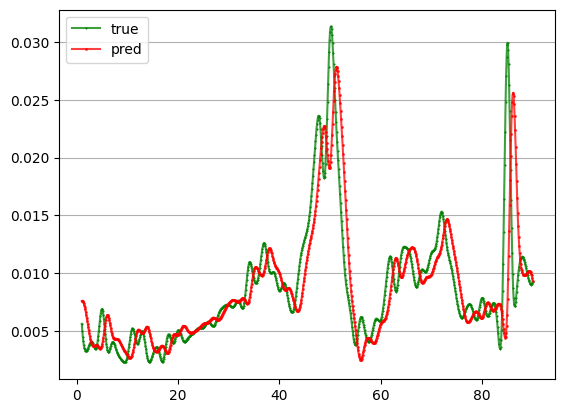

In [74]:
lstm_test(data_test, model_path, m, n, input_size, hidden_size, num_layers, output_size, batch_size, device)

### 真实预测

In [11]:
class MLP(nn.Module):
    def __init__(self, seq_len, input_size, device):
        super(MLP, self).__init__()
        self.seq_len = seq_len
        self.input_size = input_size
        self.device = device
        self.nn = torch.nn.Sequential(
            nn.Linear(seq_len * input_size, 128),
            torch.nn.ReLU(),
            nn.Linear(128, 256),
            torch.nn.ReLU(),
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)

    def forward(self, x):
        # x(batch_size, seq_len, input_size)
        x = x.view(x.shape[0], -1).to(device)
        x = self.nn(x)
        return x

In [12]:
from torch.optim.lr_scheduler import StepLR as StepLR
from tqdm import tqdm
from copy import deepcopy

def get_val_loss(model, Val, loss_function, device):
    model.eval()
    val_loss = []
    for (seq, label) in Val:
        seq = seq.to(device)
        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        val_loss.append(loss.item())

    return sum(val_loss)/len(val_loss)# MSE


def mlp_train(data_train, Val, path, input_size, batch_size, optimizer = 'adam', max_epochs = 20, lr = 0.01, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    weight_decay = 0.0001
    step_size = 5
    gamma = 0.1

    seq_len = 5

    model = MLP(seq_len=seq_len, input_size=input_size, device=device)

    loss_function = nn.MSELoss().to(device)
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                     weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=0.9, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in range(max_epochs):
        train_loss = []
        for (seq, label) in data_train:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        # validation
        val_loss = get_val_loss(model, Val, loss_function, device)
        if epoch > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = deepcopy(model)

        if epoch % 10 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

In [13]:
input_size=1
batch_size = 24
optimizer = 'adam'
max_epochs = 20
lr = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model_path = './practice/covid19/mlp_model/best_model_mlp.model'
data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size)
mlp_train(data_train, data_validate, model_path, input_size, batch_size, optimizer, max_epochs, lr, device)

cuda:0
data processing...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (24x24 and 5x128)